# Phase I: Task 1 - Overfit with the Smallest Possible Model
5390<br>
Elaina Rohlfing


**This notebook explores a variety of different architectures to determine the smallest viable model that can achieve overfitting on the Morel-Dataset. This exploration is done by repeted adjustments to number of Conv2D layers and filters in the convolutional base, while the attached dense classifier remains relatively unchanged.**
<br><br>
**In this experiment the goal is to minimize the *parameters* of the model rather than the architecture itself.**

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

## Loading the data

Before finalizing, update this cell to import either locally or from git.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**For the purposes of reproducibility, the dataset has already been shuffled and split into Train/Validate/Test sets. We will need these individual development sets for the subsequent tasks, but for this first task we are interested in the model's ability to overfit on the dataset as a whole.**
<br><br>
**After unzipping the dataset, we create a new "overfitting" directory and transfer all of our samples into this single directory. (While keeping the classes separate, of course!) To ensure the image transfer was successful, we print the total number of files found for each class.**

In [3]:
! rm -rf morel-dataset
! unzip -qq "/content/drive/MyDrive/Colab Notebooks/morel-dataset.zip"
! mv morel-dataset* morel-dataset

In [4]:
! mkdir /content/morel-dataset/overfit
! mkdir /content/morel-dataset/overfit/morel
! mkdir /content/morel-dataset/overfit/none

! mv /content/morel-dataset/train/morel/* /content/morel-dataset/overfit/morel/
! mv /content/morel-dataset/train/none/*  /content/morel-dataset/overfit/none/
! mv /content/morel-dataset/validation/morel/* /content/morel-dataset/overfit/morel/
! mv /content/morel-dataset/validation/none/*  /content/morel-dataset/overfit/none/
! mv /content/morel-dataset/test/morel/* /content/morel-dataset/overfit/morel/
! mv /content/morel-dataset/test/none/*  /content/morel-dataset/overfit/none/

! ls -l /content/morel-dataset/overfit/morel | wc -l
! ls -l /content/morel-dataset/overfit/none | wc -l

397
397


## Prepare the images (training and validation)
**A couple of functions are defined below to help with reviewing ImageDataGenerator results. These functions make it easier to check whether image pre-processing worked as expected.**

In [5]:
# Review details of dataset
def print_data_details(data):
    print(f'Classes and Class Indicies:  {data.class_indices}')
    print(f'Batch size for samples:      {data.batch_size}')
    print(f'Total number of samples:     {data.samples}')
    print(f'Size (shape) of each sample: {data.image_shape}')
    imgs, lbls = data[0]
    print(f'Preview labels:      {lbls[:5]}')

    # check baseline accurracy (for majority class in binary classification)
    num_class0 = data.classes[data.classes == 0].size
    num_class1 = data.classes[data.classes == 1].size
    class1_relative_size = (100 * (num_class1/(num_class0 + num_class1)))
    class0_relative_size = (100 - class1_relative_size)
    if class1_relative_size > class0_relative_size:
        print(f'\nMajority class is class 1\nBaseline accuracy for this dataset is: {class1_relative_size:.2f}%')
    elif class1_relative_size < class0_relative_size:
        print(f'\nMajority class is class 0\nBaseline accuracy for this dataset is: {class0_relative_size:.2f}%')
    else:
        print(f'\nThe classes in this dataset are balanced\nBaseline accuracy is: {class0_relative_size:.2f}%')

# Takes one batch full of images
def display_image(dataset, img_index=0, batch_index=0):
    images, labels = dataset[batch_index]
    class_index = int(labels[img_index])
    classes = list(dataset.class_indices.keys())

    plt.imshow(images[img_index])
    plt.title(f"{str(labels[img_index])} {classes[class_index]}")
    plt.axis("off")

**Using the ImageDataGenerator, the images are rescaled by 255 to normalize them, the image shape is set to 256 by 256, and the batch size is given a moderate size of 32. A seed is set for the purposes of reproducibility.**
<br><br>
**You may notice that the image shape is rather large, but you will see in image preview below that we will need this high level of detail to compensate for cases when the morels are far away and quite small. It is important to note that the large images will slow down the training process.**
<br><br>
**The batch number is mearly a starting point and can be adjusted later, when the model begins training.**

Found 792 images belonging to 2 classes.


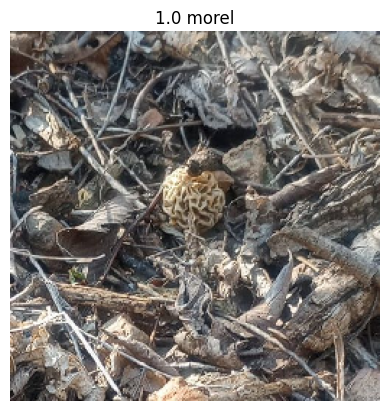

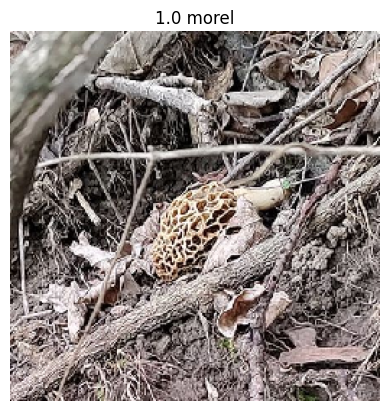

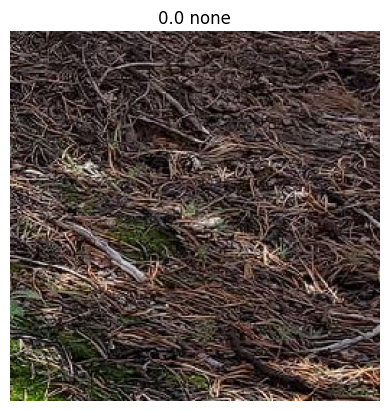

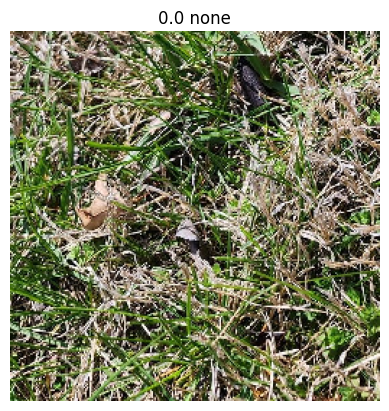

Classes and Class Indicies:  {'none': 0, 'morel': 1}
Batch size for samples:      32
Total number of samples:     792
Size (shape) of each sample: (256, 256, 3)
Preview labels:      [1. 0. 0. 1. 0.]

The classes in this dataset are balanced
Baseline accuracy is: 50.00%


In [7]:
my_generator = ImageDataGenerator(rescale=1./255)
train_set = my_generator.flow_from_directory( "./morel-dataset/overfit", target_size=(256,256),
                                             shuffle=True, seed=237, class_mode='binary',
                                             classes=["none", "morel"], batch_size=(32))

for i in range(0, 32, 10):
    display_image(train_set, i, 1)
    plt.show()
print_data_details(train_set)

# Function to plot learning curves

**These functions help visualize how training has progressed by providing plots for accurracy and loss.**

In [91]:
def plot_learning_curves(hist, title):
    fig, axs = plt.subplots(2, 1, figsize=(6, 7))
    epochs = range(1, len(hist.history['loss']) + 1)

    axs[0].plot(epochs, hist.history['accuracy'], label='Training Accuracy')
    axs[0].set_title("Accuracy for " + title)
    axs[0].set_ylabel("Accuracy")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylim([0, 1])
    axs[0].legend()

    axs[1].plot(epochs, hist.history['loss'], label='Training Loss')
    axs[1].set_title("Loss for " + title)
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Loss")
    axs[1].set_ylim([0, 1])
    axs[1].legend()

    plt.tight_layout()
    plt.show()

def plot_multiple_history(histories, history_labels, title):
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 7))

    colors = list([color for color, rgb in mcolors.CSS4_COLORS.items() if mcolors.rgb_to_hsv(mcolors.to_rgba(rgb)[:3])[2] < 0.9])

    # Plot training accuracy
    for i, h in enumerate(histories):
        axs[0].plot(h.history['accuracy'], label=f'Train Acc {history_labels[i]}', color=colors[i])
    axs[0].set_title(f'Accuracy - Model {i+1}')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_ylim([0, 1])
    axs[0].legend()

    # Plot training loss
    for i, h in enumerate(histories):
        axs[1].plot(h.history['loss'], label=f'Train Loss {history_labels[i]}', color=colors[i])
    axs[1].set_title(f'Loss - Model {i+1}')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].set_ylim([0, 1])
    axs[1].legend()

    plt.tight_layout()
    plt.show()

def calculate_metrics(model, data_generator):
    Y = np.array([]) # true labels
    P = np.array([]) # predicted values
    num_batches = data_generator.samples // data_generator.batch_size

    # get predictions for entire dataset
    for i in range(num_batches):
        x, y = data_generator.next()
        p = model.predict(x)
        Y = np.concatenate((Y, y))
        P = np.concatenate((P, p.flatten()))
    P = np.round(P)

    # calculate metrics
    accuracy = accuracy_score(Y, P)
    precision = precision_score(Y, P)
    recall = recall_score(Y, P)
    f1 = f1_score(Y, P)

    # get model architecture
    num_layers = len(model.layers)
    num_params = model.count_params()

    print(f'-----------------------------------------------------------------------')
    print(f'Metrics for {model.name} with {num_params}, {num_layers} layers:')
    print(f'-----------------------------------------------------------------------')
    print(f'Accuracy:         {accuracy:.4f}')
    print(f'Precision:        {precision:.4f}')
    print(f'Recall:           {recall:.4f}')
    print(f'F1:               {f1:.4f}')
    print(f'-----------------------------------------------------------------------')


# 1. Build the smallest possible model ("model")
**Now we finally begin testing potential architectures. As stated above, we are interested in the model with the smallest number of parameters. The corresponding architecture size will vary.**
<br><br>
**Note that careful attention is paid to the dense classifier to ensure that their parameters never exceed the number of parameters in the convolutional base.**

In [102]:
# Decreasing filters
# 7K params: In about 60 epochs, with batch size 128, this overfits with 100% accuracy
def model_too_large():
    num_filters = [16, 8, 4]
    filter_shape = (3, 3)
    inputshape = train_set.image_shape
    pad = 'same'
    pool = (4, 4)
    model = models.Sequential()
    model.add(layers.Conv2D(num_filters[0], kernel_size=filter_shape, activation='relu', padding=pad, input_shape=inputshape, name="first_layer_conv"))
    model.add(layers.MaxPooling2D(pool_size=pool, padding=pad, name="first_layer_pool"))
    model.add(layers.Conv2D(num_filters[1], kernel_size=filter_shape, activation='relu', padding=pad, input_shape=inputshape))
    model.add(layers.MaxPooling2D(pool_size=pool, padding=pad))
    model.add(layers.Conv2D(num_filters[2], kernel_size=filter_shape, activation='relu', padding=pad, input_shape=inputshape))
    model.add(layers.Flatten())
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model;

# Increasing filters
# 6K params:
def model_too_large_reverse():
    num_filters = [4, 8, 16, 24]
    filter_shape = (3, 3)
    inputshape = train_set.image_shape
    pad = 'same'
    pool = (4, 4)
    model = models.Sequential()
    model.add(layers.Conv2D(num_filters[0], kernel_size=filter_shape, activation='relu', padding=pad, input_shape=inputshape, name="first_layer_conv"))
    model.add(layers.MaxPooling2D(pool_size=pool, padding=pad, name="first_layer_pool"))
    model.add(layers.Conv2D(num_filters[1], kernel_size=filter_shape, activation='relu', padding=pad, input_shape=inputshape))
    model.add(layers.MaxPooling2D(pool_size=pool, padding=pad))
    model.add(layers.Conv2D(num_filters[2], kernel_size=filter_shape, activation='relu', padding=pad, input_shape=inputshape))
    model.add(layers.MaxPooling2D(pool_size=pool, padding=pad))
    model.add(layers.Conv2D(num_filters[3], kernel_size=filter_shape, activation='relu', padding=pad, input_shape=inputshape))
    model.add(layers.Flatten())
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model;

# Increased pooling
# 5k params:
def model_too_large_pooled():
    num_filters = [4,8,16,24]
    filter_shape = (3, 3)
    inputshape = train_set.image_shape
    pad = 'same'
    pool = (8, 8)
    model = models.Sequential()
    model.add(layers.Conv2D(num_filters[0], kernel_size=filter_shape, activation='relu', padding=pad, input_shape=inputshape, name="first_layer_conv"))
    model.add(layers.MaxPooling2D(pool_size=pool, padding=pad, name="first_layer_pool"))
    model.add(layers.Conv2D(num_filters[1], kernel_size=filter_shape, activation='relu', padding=pad, input_shape=inputshape))
    model.add(layers.MaxPooling2D(pool_size=pool, padding=pad))
    model.add(layers.Conv2D(num_filters[2], kernel_size=filter_shape, activation='relu', padding=pad, input_shape=inputshape))
    model.add(layers.MaxPooling2D(pool_size=pool, padding=pad))
    model.add(layers.Conv2D(num_filters[3], kernel_size=filter_shape, activation='relu', padding=pad, input_shape=inputshape))
    model.add(layers.Flatten())
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model;

# Increasing filters 4,6,6
# 1155 params: In about 200 epochs, with batch size 128, this model's accuracy is 96%
def model_large():
    num_filters = [4, 6, 6]
    filter_shape = (3, 3)
    inputshape = train_set.image_shape
    pad = 'same'
    pool = (8, 8)
    model = models.Sequential()
    model.add(layers.Conv2D(num_filters[0], kernel_size=filter_shape, activation='relu', padding=pad, input_shape=inputshape))
    model.add(layers.MaxPooling2D(pool_size=pool, padding=pad, name="first_layer_pool"))
    model.add(layers.Conv2D(num_filters[1], kernel_size=filter_shape, activation='relu', padding=pad))
    model.add(layers.MaxPooling2D(pool_size=pool, padding=pad))
    model.add(layers.Conv2D(num_filters[2], kernel_size=filter_shape, activation='relu', padding=pad))
    model.add(layers.Flatten())
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model;

# BEST Decreasing filters 6,6,4
# 1049 params: In about 200 epochs, with batch size 128, this model's accuracy is 96%
def model_large_reverse():
    num_filters = [6, 6, 4]
    filter_shape = (3, 3)
    inputshape = train_set.image_shape
    pad = 'same'
    pool = (8, 8)
    model = models.Sequential()
    model.add(layers.Conv2D(num_filters[0], kernel_size=filter_shape, activation='relu', padding=pad, input_shape=inputshape))
    model.add(layers.MaxPooling2D(pool_size=pool, padding=pad, name="first_layer_pool"))
    model.add(layers.Conv2D(num_filters[1], kernel_size=filter_shape, activation='relu', padding=pad))
    model.add(layers.MaxPooling2D(pool_size=pool, padding=pad))
    model.add(layers.Conv2D(num_filters[2], kernel_size=filter_shape, activation='relu', padding=pad))
    model.add(layers.Flatten())
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model;

# Increasing filters 2,4,6
# 649 params: In about 130 epochs, with batch size 128, this model's accuracy is 80%
# 649 params: In about 98 more epochs, with batch size 128, this model's accuracy is only 86%
def model_small():
    num_filters = [2, 4, 6]
    filter_shape = (3, 3)
    inputshape = train_set.image_shape
    pad = 'same'
    pool = (6, 6)
    model = models.Sequential()
    model.add(layers.Conv2D(num_filters[0], kernel_size=filter_shape, activation='relu', padding=pad, input_shape=inputshape, name="first_layer_conv"))
    model.add(layers.MaxPooling2D(pool_size=pool, padding=pad, name="first_layer_pool"))
    model.add(layers.Conv2D(num_filters[1], kernel_size=filter_shape, activation='relu', padding=pad))
    model.add(layers.MaxPooling2D(pool_size=pool, padding=pad))
    model.add(layers.Conv2D(num_filters[2], kernel_size=filter_shape, activation='relu', padding=pad))
    model.add(layers.MaxPooling2D(pool_size=pool, padding=pad))
    model.add(layers.Conv2D(num_filters[3], kernel_size=filter_shape, activation='relu', padding=pad))
    model.add(layers.Flatten())
    model.add(layers.Dense(3, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model;

# Decreasing filters 6,4,2
# 565 Params: in about 175 epochs, with batch size 128, this model's accuracy is 86%
# 565 Params: in 100 more epochs, with batch size 128, this model's accuracy is 90%
def model_small_reverse():
    num_filters = [6, 4, 2]
    filter_shape = (3, 3)
    inputshape = train_set.image_shape
    pad = 'same'
    pool = (8, 8)
    model = models.Sequential()
    model.add(layers.Conv2D(num_filters[0], kernel_size=filter_shape, activation='relu', padding=pad, input_shape=inputshape, name="first_layer_conv"))
    model.add(layers.MaxPooling2D(pool_size=pool, padding=pad, name="first_layer_pool"))
    model.add(layers.Conv2D(num_filters[1], kernel_size=filter_shape, activation='relu', padding=pad))
    model.add(layers.MaxPooling2D(pool_size=pool, padding=pad))
    model.add(layers.Conv2D(num_filters[2], kernel_size=filter_shape, activation='relu', padding=pad))
    model.add(layers.Flatten())
    model.add(layers.Dense(3, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model;

# uniform filters 4,4,4
# 607 params: In about 200 epochs, with batch size 128, this model's accuracy is 86% - Struggling to go higher
def model_medium():
    num_filters = [4, 4, 4]
    filter_shape = (3, 3)
    inputshape = train_set.image_shape
    pad = 'same'
    pool = (8, 8)
    model = models.Sequential()
    model.add(layers.Conv2D(num_filters[0], kernel_size=filter_shape, activation='relu', padding=pad, input_shape=inputshape, name="first_layer_conv"))
    model.add(layers.MaxPooling2D(pool_size=pool, padding=pad, name="first_layer_pool"))
    model.add(layers.Conv2D(num_filters[1], kernel_size=filter_shape, activation='relu', padding=pad))
    model.add(layers.MaxPooling2D(pool_size=pool, padding=pad))
    model.add(layers.Conv2D(num_filters[2], kernel_size=filter_shape, activation='relu', padding=pad))
    model.add(layers.Flatten())
    model.add(layers.Dense(3, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model;

In [14]:
# lists to store history records
history_list = []
history_labels = []

## Compile the largest model [7031 params] to check for errors & Train
* Epoch 71/200 5s 212ms/step - loss: 0.0051 - accuracy: 1.0000



### Inspect the Model

In [15]:
model5 = model_too_large()
model5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 first_layer_conv (Conv2D)   (None, 256, 256, 16)      448       
                                                                 
 first_layer_pool (MaxPooli  (None, 64, 64, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 8)         1160      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 8)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 4)         292       
                                                                 
 flatten (Flatten)           (None, 1024)              0

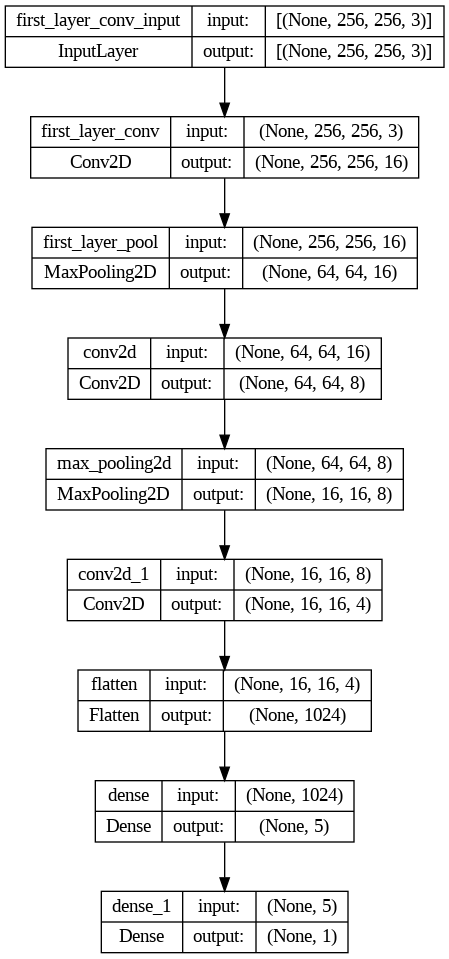

In [16]:
plot_model(model5, show_layer_names=True, show_shapes=True)

### Train

In [17]:
model5.compile(optimizer='rmsprop', loss ='binary_crossentropy', metrics=['accuracy'])
history5 = model5.fit(train_set, epochs=100, verbose=1, batch_size=128)
history_list.append(history5)
history_labels.append("Model Too Large [7031]")

Epoch 1/100
25/25 [==============================] - 9s 161ms/step - loss: 0.6954 - accuracy: 0.4899
Epoch 2/100
25/25 [==============================] - 4s 177ms/step - loss: 0.6877 - accuracy: 0.5467
Epoch 3/100
25/25 [==============================] - 4s 177ms/step - loss: 0.6750 - accuracy: 0.5909
Epoch 4/100
25/25 [==============================] - 4s 176ms/step - loss: 0.6519 - accuracy: 0.6199
Epoch 5/100
25/25 [==============================] - 5s 180ms/step - loss: 0.6385 - accuracy: 0.6288
Epoch 6/100
25/25 [==============================] - 5s 184ms/step - loss: 0.6230 - accuracy: 0.6692
Epoch 7/100
25/25 [==============================] - 4s 175ms/step - loss: 0.6199 - accuracy: 0.6780
Epoch 8/100
25/25 [==============================] - 4s 173ms/step - loss: 0.5871 - accuracy: 0.6856
Epoch 9/100
25/25 [==============================] - 4s 171ms/step - loss: 0.5746 - accuracy: 0.7096
Epoch 10/100
25/25 [==============================] - 4s 175ms/step - loss: 0.5589 - accura

### Review

1/1 [==============================] - 0s 29ms/step
-----------------------------------------------------------------------
Metrics for sequential with 7031, 8 layers:
-----------------------------------------------------------------------
Accuracy:         1.0000
Precision:        1.0000
Recall:           1.0000
F1:               1.0000
-----------------------------------------------------------------------
25/25 [==============================] - 4s 173ms/step - loss: 0.0015 - accuracy: 1.0000


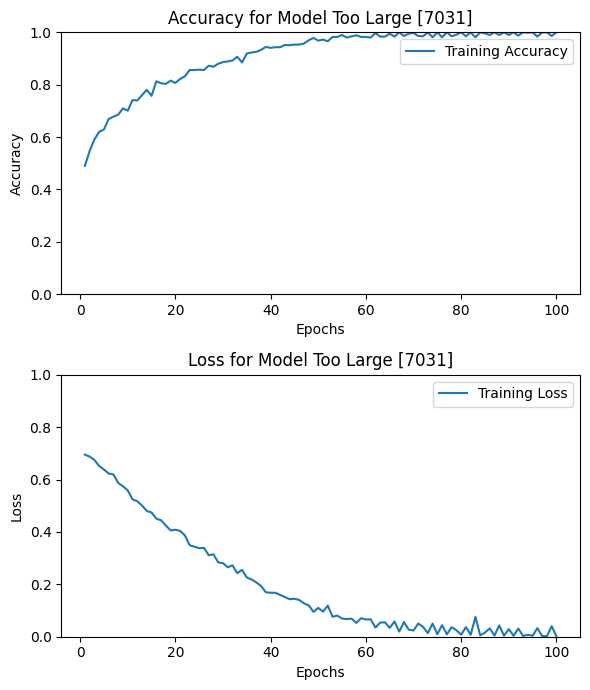

In [70]:
calculate_metrics(model5, train_set)
model5.evaluate(train_set)
plot_learning_curves(history5, "Model Too Large [7031]")

## Compile the model7 [6987 params] to check for errors & Train
* Epoch

### Inspect the Model

In [76]:
model7 = model_too_large_reverse()
model7.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 first_layer_conv (Conv2D)   (None, 256, 256, 4)       112       
                                                                 
 first_layer_pool (MaxPooli  (None, 64, 64, 4)         0         
 ng2D)                                                           
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 8)         296       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 16)        1168      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 4, 4, 16)         

### Train

In [77]:
model7.compile(optimizer='rmsprop', loss = 'binary_crossentropy', metrics=['accuracy'])
history7 = model7.fit(train_set, epochs=100, verbose=1, batch_size=128)
history_list.append(history7)
history_labels.append("Model Too Large Reverse [6987]")

Epoch 1/100
25/25 [==============================] - 6s 176ms/step - loss: 0.6939 - accuracy: 0.4937
Epoch 2/100
25/25 [==============================] - 5s 191ms/step - loss: 0.6932 - accuracy: 0.5177
Epoch 3/100
25/25 [==============================] - 5s 190ms/step - loss: 0.6900 - accuracy: 0.5429
Epoch 4/100
25/25 [==============================] - 5s 190ms/step - loss: 0.6883 - accuracy: 0.5530
Epoch 5/100
25/25 [==============================] - 5s 189ms/step - loss: 0.6846 - accuracy: 0.5821
Epoch 6/100
25/25 [==============================] - 5s 188ms/step - loss: 0.6737 - accuracy: 0.5960
Epoch 7/100
25/25 [==============================] - 5s 190ms/step - loss: 0.6613 - accuracy: 0.6098
Epoch 8/100
25/25 [==============================] - 5s 195ms/step - loss: 0.6453 - accuracy: 0.6326
Epoch 9/100
25/25 [==============================] - 5s 197ms/step - loss: 0.6303 - accuracy: 0.6376
Epoch 10/100
25/25 [==============================] - 5s 191ms/step - loss: 0.6229 - accura

In [79]:
model7.fit(train_set, epochs=50, verbose=1, batch_size=128)

Epoch 1/50
25/25 [==============================] - 4s 176ms/step - loss: 0.0139 - accuracy: 0.9924
Epoch 2/50
25/25 [==============================] - 4s 176ms/step - loss: 0.0059 - accuracy: 0.9987
Epoch 3/50
25/25 [==============================] - 4s 173ms/step - loss: 0.0205 - accuracy: 0.9937
Epoch 4/50
25/25 [==============================] - 4s 174ms/step - loss: 0.0104 - accuracy: 0.9975
Epoch 5/50
25/25 [==============================] - 4s 173ms/step - loss: 0.0030 - accuracy: 0.9987
Epoch 6/50
25/25 [==============================] - 4s 170ms/step - loss: 0.0285 - accuracy: 0.9874
Epoch 7/50
25/25 [==============================] - 4s 173ms/step - loss: 0.0026 - accuracy: 0.9987
Epoch 8/50
25/25 [==============================] - 4s 175ms/step - loss: 0.0082 - accuracy: 0.9962
Epoch 9/50
25/25 [==============================] - 4s 175ms/step - loss: 0.0049 - accuracy: 0.9987
Epoch 10/50
25/25 [==============================] - 5s 181ms/step - loss: 0.0021 - accuracy: 0.9987

### Review

1/1 [==============================] - 0s 44ms/step
-----------------------------------------------------------------------
Metrics for sequential_2 with 6987, 10 layers:
-----------------------------------------------------------------------
Accuracy:         0.9987
Precision:        1.0000
Recall:           0.9974
F1:               0.9987
-----------------------------------------------------------------------
25/25 [==============================] - 4s 169ms/step - loss: 0.0038 - accuracy: 0.9987


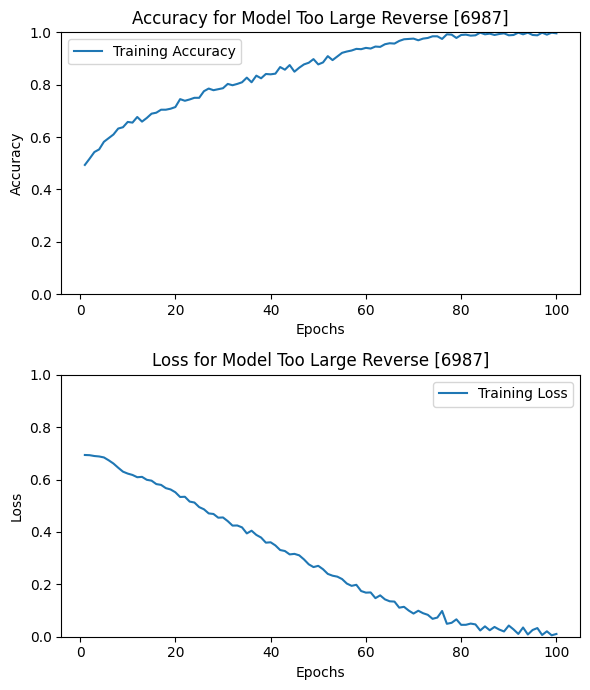

In [78]:
calculate_metrics(model7, train_set)
model7.evaluate(train_set)
plot_learning_curves(history7, "Model Too Large Reverse [6987]")

In [80]:
print('Model Too Large Reverse [6987] after 50 more epochs:')
calculate_metrics(model7, train_set)
model7.evaluate(train_set)

Model Too Large Reverse [6987] after 50 more epochs:
1/1 [==============================] - 0s 29ms/step
-----------------------------------------------------------------------
Metrics for sequential_2 with 6987, 10 layers:
-----------------------------------------------------------------------
Accuracy:         1.0000
Precision:        1.0000
Recall:           1.0000
F1:               1.0000
-----------------------------------------------------------------------
25/25 [==============================] - 4s 173ms/step - loss: 9.0865e-05 - accuracy: 1.0000


[9.086520003620535e-05, 1.0]

## Compile the model8 :[5187 params] to check for errors & Train
* Epoch

### Inspect the Model

In [83]:
model8 = model_too_large_pooled()
model8.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 first_layer_conv (Conv2D)   (None, 256, 256, 4)       112       
                                                                 
 first_layer_pool (MaxPooli  (None, 32, 32, 4)         0         
 ng2D)                                                           
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 8)         296       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 4, 4, 8)           0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 4, 4, 16)          1168      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 1, 1, 16)         

### Train

In [84]:
model8.compile(optimizer='rmsprop', loss = 'binary_crossentropy', metrics=['accuracy'])
history8 = model8.fit(train_set, epochs=200, verbose=1, batch_size=128)
history_list.append(history8)
history_labels.append("Model Too Large Pooled [5187]")

Epoch 1/200
25/25 [==============================] - 5s 160ms/step - loss: 0.6934 - accuracy: 0.5000
Epoch 2/200
25/25 [==============================] - 4s 178ms/step - loss: 0.6931 - accuracy: 0.5013
Epoch 3/200
25/25 [==============================] - 4s 171ms/step - loss: 0.6933 - accuracy: 0.5152
Epoch 4/200
25/25 [==============================] - 4s 173ms/step - loss: 0.6928 - accuracy: 0.4987
Epoch 5/200
25/25 [==============================] - 4s 172ms/step - loss: 0.6927 - accuracy: 0.5316
Epoch 6/200
25/25 [==============================] - 4s 174ms/step - loss: 0.6924 - accuracy: 0.5101
Epoch 7/200
25/25 [==============================] - 4s 174ms/step - loss: 0.6925 - accuracy: 0.5114
Epoch 8/200
25/25 [==============================] - 4s 173ms/step - loss: 0.6913 - accuracy: 0.5568
Epoch 9/200
25/25 [==============================] - 4s 174ms/step - loss: 0.6897 - accuracy: 0.5720
Epoch 10/200
25/25 [==============================] - 4s 173ms/step - loss: 0.6885 - accura

### Review

1/1 [==============================] - 0s 29ms/step
-----------------------------------------------------------------------
Metrics for sequential_3 with 5187, 10 layers:
-----------------------------------------------------------------------
Accuracy:         0.9816
Precision:        0.9918
Recall:           0.9707
F1:               0.9812
-----------------------------------------------------------------------
25/25 [==============================] - 4s 170ms/step - loss: 0.0836 - accuracy: 0.9836


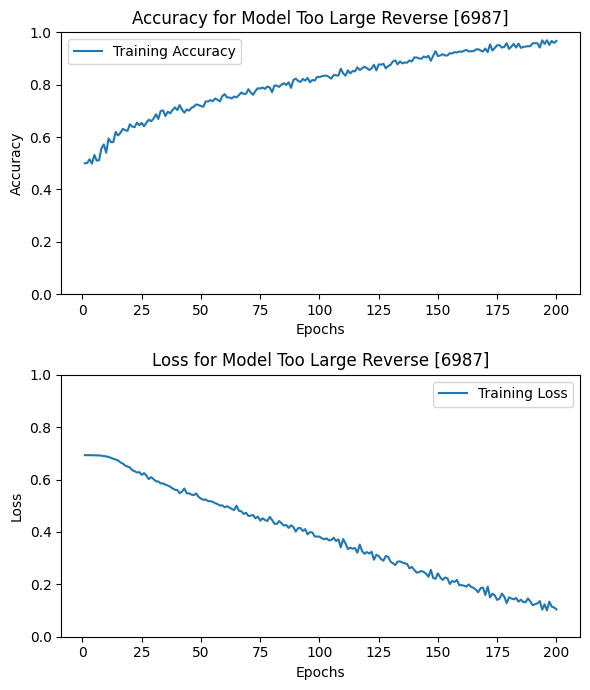

In [85]:
calculate_metrics(model8, train_set)
model8.evaluate(train_set)
plot_learning_curves(history8, "Model Too Large Reverse [6987]")

## Compile the model1 [1155 params] to check for errors & Train

### Inspect the Model

In [71]:
model1 = model_large()
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 256, 256, 4)       112       
                                                                 
 first_layer_pool (MaxPooli  (None, 32, 32, 4)         0         
 ng2D)                                                           
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 6)         222       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4, 4, 6)           0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 4, 6)           330       
                                                                 
 flatten_1 (Flatten)         (None, 96)               

### Train

In [73]:
model1.compile(optimizer='rmsprop', loss = 'binary_crossentropy', metrics=['accuracy'])
history1 = model1.fit(train_set, epochs=250, verbose=1, batch_size=128)
history_list.append(history1)
history_labels.append("Model Large [1155]")

Epoch 1/250
25/25 [==============================] - 6s 166ms/step - loss: 0.6957 - accuracy: 0.5025
Epoch 2/250
25/25 [==============================] - 4s 178ms/step - loss: 0.6925 - accuracy: 0.5088
Epoch 3/250
25/25 [==============================] - 4s 177ms/step - loss: 0.6909 - accuracy: 0.5303
Epoch 4/250
25/25 [==============================] - 4s 176ms/step - loss: 0.6887 - accuracy: 0.5316
Epoch 5/250
25/25 [==============================] - 4s 174ms/step - loss: 0.6855 - accuracy: 0.5859
Epoch 6/250
25/25 [==============================] - 4s 176ms/step - loss: 0.6828 - accuracy: 0.5947
Epoch 7/250
25/25 [==============================] - 4s 176ms/step - loss: 0.6747 - accuracy: 0.5960
Epoch 8/250
25/25 [==============================] - 4s 178ms/step - loss: 0.6679 - accuracy: 0.5960
Epoch 9/250
25/25 [==============================] - 4s 177ms/step - loss: 0.6635 - accuracy: 0.5997
Epoch 10/250
25/25 [==============================] - 4s 176ms/step - loss: 0.6558 - accura

### Review

1/1 [==============================] - 0s 31ms/step
-----------------------------------------------------------------------
Metrics for sequential_1 with 1155, 8 layers:
-----------------------------------------------------------------------
Accuracy:         0.9816
Precision:        0.9644
Recall:           1.0000
F1:               0.9819
-----------------------------------------------------------------------
25/25 [==============================] - 5s 192ms/step - loss: 0.0661 - accuracy: 0.9848


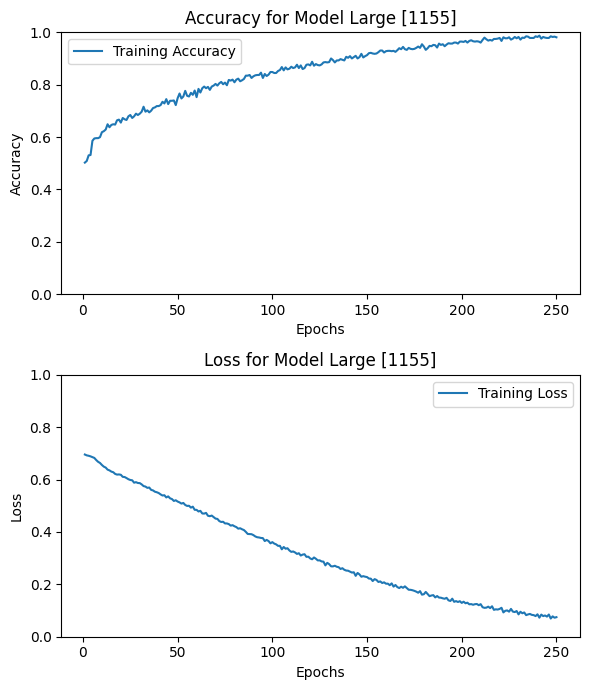

In [74]:
calculate_metrics(model1, train_set)
model1.evaluate(train_set)
plot_learning_curves(history1, "Model Large [1155]")

## Compile the model6 [1049 params] to check for errors & Train
* Epoch 200/200 4s 173ms/step - loss: 0.1700 - accuracy: 0.9565

### Train

In [86]:
model6 = model_large_reverse()
model6.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 256, 256, 6)       168       
                                                                 
 first_layer_pool (MaxPooli  (None, 32, 32, 6)         0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 32, 32, 6)         330       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 4, 4, 6)           0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 4, 4, 4)           220       
                                                                 
 flatten_4 (Flatten)         (None, 64)               

In [87]:
model6.compile(optimizer='rmsprop', loss = 'binary_crossentropy', metrics=['accuracy'])
history6 = model6.fit(train_set, epochs=250, verbose=1, batch_size=128)
history_list.append(history6)
history_labels.append("Model Large Reverse [1049]")

Epoch 1/250
25/25 [==============================] - 5s 155ms/step - loss: 0.6947 - accuracy: 0.4760
Epoch 2/250
25/25 [==============================] - 4s 176ms/step - loss: 0.6943 - accuracy: 0.4987
Epoch 3/250
25/25 [==============================] - 4s 173ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 4/250
25/25 [==============================] - 4s 173ms/step - loss: 0.6921 - accuracy: 0.5013
Epoch 5/250
25/25 [==============================] - 4s 169ms/step - loss: 0.6883 - accuracy: 0.5669
Epoch 6/250
25/25 [==============================] - 4s 172ms/step - loss: 0.6860 - accuracy: 0.5568
Epoch 7/250
25/25 [==============================] - 4s 175ms/step - loss: 0.6806 - accuracy: 0.5694
Epoch 8/250
25/25 [==============================] - 4s 176ms/step - loss: 0.6767 - accuracy: 0.5922
Epoch 9/250
25/25 [==============================] - 4s 173ms/step - loss: 0.6724 - accuracy: 0.6098
Epoch 10/250
25/25 [==============================] - 4s 176ms/step - loss: 0.6662 - accura

### Review

1/1 [==============================] - 0s 29ms/step
-----------------------------------------------------------------------
Metrics for sequential_4 with 1049, 8 layers:
-----------------------------------------------------------------------
Accuracy:         0.9987
Precision:        0.9974
Recall:           1.0000
F1:               0.9987
-----------------------------------------------------------------------
25/25 [==============================] - 5s 176ms/step - loss: 0.0290 - accuracy: 0.9975


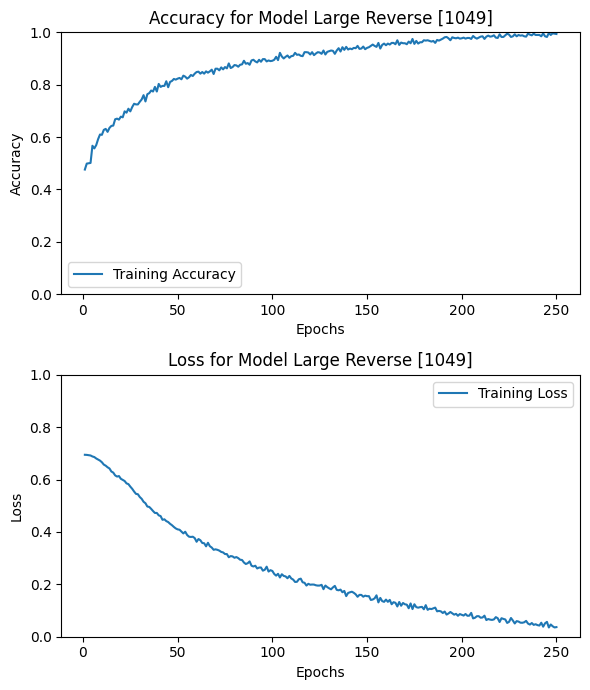

In [88]:
calculate_metrics(model6, train_set)
model6.evaluate(train_set)
plot_learning_curves(history6, "Model Large Reverse [1049]")

# ditch these

## Compile the model2 [649 params] to check for errors & Train
* Epoch 124/200 5s 220ms/step - loss: 0.4570 - accuracy: 0.8062
* Epoch 98/100 4s 182ms/step - loss: 0.3428 - accuracy: 0.8553

In [93]:
model2 = model_small()
model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 first_layer_conv (Conv2D)   (None, 256, 256, 2)       56        
                                                                 
 first_layer_pool (MaxPooli  (None, 32, 32, 2)         0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 32, 32, 4)         76        
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 4, 4, 4)           0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 4, 4, 6)           222       
                                                                 
 flatten_5 (Flatten)         (None, 96)               

### Train

In [ ]:
model2.compile(optimizer='rmsprop', loss = 'binary_crossentropy', metrics=['accuracy'])
history2 = model2.fit(train_set, epochs=250, verbose=1, batch_size=128)
history_list.append(history2)
history_labels.append("Model Small [649]")

In [ ]:
#history2 = model2.fit(train_set, epochs=200, verbose=1,  batch_size=128)

Epoch 1/200
23/23 [==============================] - 9s 209ms/step - loss: 0.6965 - accuracy: 0.5000
Epoch 2/200
23/23 [==============================] - 5s 204ms/step - loss: 0.6912 - accuracy: 0.5197
Epoch 3/200
23/23 [==============================] - 4s 176ms/step - loss: 0.6903 - accuracy: 0.5267
Epoch 4/200
23/23 [==============================] - 5s 236ms/step - loss: 0.6894 - accuracy: 0.5801
Epoch 5/200
23/23 [==============================] - 4s 183ms/step - loss: 0.6876 - accuracy: 0.5969
Epoch 6/200
23/23 [==============================] - 5s 235ms/step - loss: 0.6855 - accuracy: 0.5955
Epoch 7/200
23/23 [==============================] - 4s 174ms/step - loss: 0.6834 - accuracy: 0.5899
Epoch 8/200
23/23 [==============================] - 4s 179ms/step - loss: 0.6824 - accuracy: 0.5660
Epoch 9/200
23/23 [==============================] - 5s 234ms/step - loss: 0.6790 - accuracy: 0.6166
Epoch 10/200
23/23 [==============================] - 4s 172ms/step - loss: 0.6746 - accura

In [ ]:
history2a = model2.fit(train_set, epochs=100, verbose=1,  batch_size=128)

Epoch 1/100
23/23 [==============================] - 4s 191ms/step - loss: 0.4496 - accuracy: 0.8006
Epoch 2/100
23/23 [==============================] - 5s 218ms/step - loss: 0.4483 - accuracy: 0.8090
Epoch 3/100
23/23 [==============================] - 6s 253ms/step - loss: 0.4475 - accuracy: 0.8090
Epoch 4/100
23/23 [==============================] - 5s 208ms/step - loss: 0.4439 - accuracy: 0.8104
Epoch 5/100
23/23 [==============================] - 6s 262ms/step - loss: 0.4451 - accuracy: 0.8048
Epoch 6/100
23/23 [==============================] - 5s 233ms/step - loss: 0.4435 - accuracy: 0.8062
Epoch 7/100
23/23 [==============================] - 6s 276ms/step - loss: 0.4407 - accuracy: 0.8104
Epoch 8/100
23/23 [==============================] - 4s 177ms/step - loss: 0.4431 - accuracy: 0.8062
Epoch 9/100
23/23 [==============================] - 4s 176ms/step - loss: 0.4414 - accuracy: 0.8090
Epoch 10/100
23/23 [==============================] - 5s 237ms/step - loss: 0.4432 - accura

### Review

In [ ]:
print("Train for 100 more epochs.")
model2.evaluate(train_set)
plot_learning_curves(history2, "Model with 649 Params, Trained on Batch 128")

23/23 [==============================] - 5s 225ms/step - loss: 0.4522 - accuracy: 0.7949


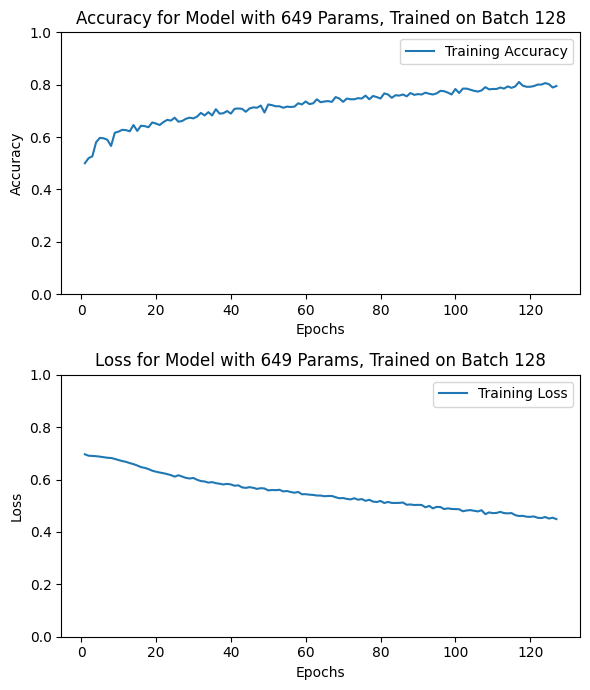

In [ ]:
model2.evaluate(train_set)
plot_learning_curves(history2, "Model with 649 Params, Trained on Batch 128")

# Comparison of All Models

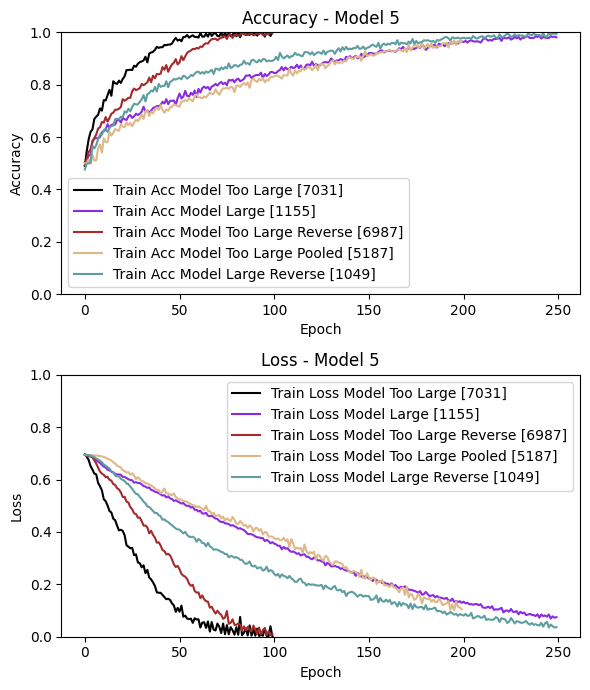

In [92]:
plot_multiple_history(history_list, history_labels, "Comparison of Training Results for Overfitting")